<ipython-input-1-6fb6c10dcda5>:70: RuntimeWarning: divide by zero encountered in true_divide
  z=K[0,0]*b/(uL-uR)
<ipython-input-1-6fb6c10dcda5>:129: RuntimeWarning: divide by zero encountered in true_divide
  z=K[0,0]*b/(uL-uR)


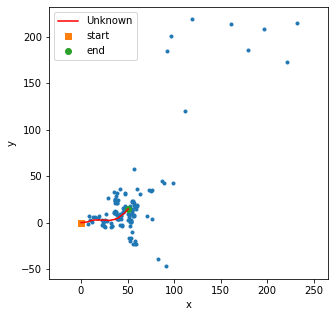

In [1]:
import numpy as np
from utils import *
from scipy.linalg import expm

if __name__ == '__main__':

    # Load the measurements
    filename = "./03.npz"
    t,features,linear_velocity,angular_velocity,K,b,imu_T_cam = load_data(filename)

    # (a) IMU Localization via EKF Prediction
    mu=np.eye(4)
    pose=np.eye(4)
    cov=np.zeros((6,6))
    W=np.array([[0.3,0,0,0,0,0],
                [0,0.3,0,0,0,0],
                [0,0,0.3,0,0,0],
                [0,0,0,0.05,0,0],
                [0,0,0,0,0.05,0],
                [0,0,0,0,0,0.05]])
    _,tao=t.shape
    for i in range(tao-1):
        omega=angular_velocity[:,i]
        v=linear_velocity[:,i]
        u_hat=np.array([[0,-omega[2],omega[1],v[0]],
                        [omega[2],0,-omega[0],v[1]],
                        [-omega[1],omega[0],0,v[2]],
                        [0,0,0,0]])
        temp=expm((t[0,i+1]-t[0,i])*u_hat)
        mu=np.dot(mu,temp)
        pose=np.dstack((pose,mu))
        omega_hat=np.array([[0,-omega[2],omega[1]],
                            [omega[2],0,-omega[0]],
                            [-omega[1],omega[0],0]])
        v_hat=np.array([[0,-v[2],v[1]],
                        [v[2],0,-v[0]],
                        [-v[1],v[0],0]])
        u_hhat=np.block([[omega_hat,v_hat],
                         [np.zeros((3,3)),omega_hat]])
        temp2=expm(-(t[0,i+1]-t[0,i])*u_hhat)
        temp3=np.dot(temp2,cov)
        cov=np.dot(temp3,expm(-(t[0,i+1]-t[0,i])*u_hhat).T)+W
        
    # (b) Landmark Mapping via EKF Update
    _,num_of_features,_=features.shape
    num_sample_features=int(num_of_features/4)
    indx_sample_features=np.arange(0,4*num_sample_features,4)
    codi_in_cam=np.ones((4,num_sample_features))
    codi_in_world=np.ones((4,num_sample_features))
    codi_in_world=np.array([-1,-1,-1,1]).reshape((4,1))*codi_in_world
    mu_car=np.eye(4)
    cov_car=np.zeros((6,6))
    real_pose=np.eye(4)
    mu_landmark=np.zeros(3*num_sample_features)
    cov_landmark=np.eye(3*num_sample_features)
    Ks=np.array([[K[0,0],0,K[0,2],0],
                 [0,K[1,1],K[1,2],0],
                 [K[0,0],0,K[0,2],-K[0,0]*b],
                 [0,K[1,1],K[1,2],0]])
    P=np.array([[1,0,0,0],
                [0,1,0,0],
                [0,0,1,0]])
    
    # initialize landmark
    uL=features[0,indx_sample_features,0]
    uR=features[2,indx_sample_features,0]
    vL=features[1,indx_sample_features,0]
    

    z=K[0,0]*b/(uL-uR)
    y=z*(vL-K[1,2])/K[1,1]
    x=z*(uL-K[0,2])/K[0,0]
    codi_in_cam[0,:]=x
    codi_in_cam[1,:]=y
    codi_in_cam[2,:]=z
    indx_valid_codi=np.where(codi_in_cam[0,:]!=float("-inf"))
    indx_valid_old=indx_valid_codi
    for index in indx_valid_codi:
        
        codi_in_imu=imu_T_cam @ codi_in_cam[:,index]
        codi_in_world[:,index]=mu_car @ codi_in_imu
    indx_nonzero_codi=np.where(codi_in_world[0,:]!=-1)[0]
        
        
    
    for k in range(len(indx_nonzero_codi)):
        if np.all(mu_landmark[3*indx_nonzero_codi[k]:3*indx_nonzero_codi[k]+3])==0:
            mu_landmark[3*indx_nonzero_codi[k]:3*indx_nonzero_codi[k]+3]=codi_in_world[0:3,indx_nonzero_codi[k]]
# (c) Visual-Inertial SLAM
# from the second time point

    #defult(1,tao)
    #EDIT HERE
    
    for j in range(1, 100):
    #EDIT HERE

        omega=angular_velocity[:,j-1]
        v=linear_velocity[:,j-1]
        u_hat=np.array([[0,-omega[2],omega[1],v[0]],
                        [omega[2],0,-omega[0],v[1]],
                        [-omega[1],omega[0],0,v[2]],
                        [0,0,0,0]])
        temp=expm((t[0,j]-t[0,j-1])*u_hat)
        #temp_flip=np.array([[temp[0,0],-temp[0,1],temp[0,2],temp[0,3]],
         #                   [-temp[1,0],temp[1,1],temp[1,2],temp[1,3]],
          #                  [temp[2,0],temp[2,1],temp[2,2],temp[2,3]],
           #                 [temp[3,0],temp[3,1],temp[3,2],temp[3,3]]])
        mu_car=np.dot(mu_car,temp)
        check1=mu_car
        omega_hat=np.array([[0,-omega[2],omega[1]],
                            [omega[2],0,-omega[0]],
                            [-omega[1],omega[0],0]])
        v_hat=np.array([[0,-v[2],v[1]],
                        [v[2],0,-v[0]],
                        [-v[1],v[0],0]])
        u_hhat=np.block([[omega_hat,v_hat],
                         [np.zeros((3,3)),omega_hat]])
        temp2=expm(-(t[0,j]-t[0,j-1])*u_hhat)
        temp3=np.dot(temp2,cov_car)
        cov_car=np.dot(temp3,expm(-(t[0,j]-t[0,j-1])*u_hhat).T)+W


        uL=features[0,indx_sample_features,j] 
        uR=features[2,indx_sample_features,j]
        vL=features[1,indx_sample_features,j]
        obs=features[:,indx_sample_features,j]
        obs_predi=np.zeros((4,num_sample_features))
        z=K[0,0]*b/(uL-uR)
        y=z*(vL-K[1,2])/K[1,1]
        x=z*(uL-K[0,2])/K[0,0]
        codi_in_cam[0,:]=x
        codi_in_cam[1,:]=y
        codi_in_cam[2,:]=z
        indx_valid_old=indx_valid_codi
        indx_valid_codi=np.where(codi_in_cam[0,:]!=float("-inf"))
        
        for index in indx_valid_codi:
            obs_valid=obs[:,index]
            codi_in_imu=imu_T_cam @ codi_in_cam[:,index]
            codi_in_world[:,index]=mu_car @ codi_in_imu
        #indx_nonzero_codi=np.where(codi_in_world[0,:]!=-1)[0]
        
        idx=indx_valid_codi[0]
        #idx_old=indx_valid_old[0]
        #idx_diff=set(idx).difference(set(idx_old))
        #idx_diff=np.array(idx_diff)

        obs_jacob=np.zeros((4*len(idx),3*num_sample_features))
        ekf_jacob=np.zeros((4*len(idx),6))
        for k in range(len(idx)):
            temp1=np.linalg.inv(mu_car) @ np.append(mu_landmark[3*idx[k]:3*idx[k]+3],1)
            temp2=np.linalg.inv(imu_T_cam) @ temp1
            obs_predi[:,idx[k]]=Ks @ temp2/temp2[2]
            temp3=Ks @ np.array([[1,0,-temp2[0]/temp2[2],0],
                                 [0,1,-temp2[1]/temp2[2],0],
                                 [0,0,0,0],
                                 [0,0,-temp2[3]/temp2[2],1]])/temp2[2]

            temp4=temp3 @ np.linalg.inv(imu_T_cam) @ np.linalg.inv(mu_car)
            obs_jacob[4*k:4*k+4,3*idx[k]:3*idx[k]+3]=temp4 @ P.T

            
            temp6=-np.array([[0,-temp1[2],temp1[1]],
                             [temp1[2],0,-temp1[0]],
                             [-temp1[1],temp1[0],0]])
            temp7=np.block([[np.eye(3),temp6],
                            [np.zeros((1,6))]])
            ekf_jacob[4*k:4*k+4,:]=-temp3 @ np.linalg.inv(imu_T_cam) @ temp7
            if np.all(mu_landmark[3*idx[k]:3*idx[k]+3])==0:
                mu_landmark[3*idx[k]:3*idx[k]+3]=codi_in_world[0:3,idx[k]]
                obs_predi[:,idx[k]]=obs_valid[:,k]
            
            
            
        temp5=(obs_jacob @ cov_landmark @ obs_jacob.T)+ 10000*np.eye(4*len(idx))
        kalman_obs=cov_landmark @ obs_jacob.T @ np.linalg.inv(temp5)
        mu_landmark=mu_landmark+kalman_obs @ (obs_valid.reshape((4*len(idx)),order='F')-obs_predi[:,idx].reshape((4*len(idx)),order='F'))
        
        
        
        temp11=np.eye(3*num_sample_features)-kalman_obs @ obs_jacob
        cov_landmark=temp11 @ cov_landmark @ cov_landmark @ temp11.T + kalman_obs @ np.eye(4*len(idx)) @kalman_obs.T
                

        temp8=(ekf_jacob @ cov_car @ ekf_jacob.T)+10000*np.eye(4*len(idx))
        kalman_car=cov_car @ ekf_jacob.T @ np.linalg.inv(temp8)
        temp9=kalman_car @ (obs_valid.reshape((4*len(idx)),order='F')-obs_predi[:,idx].reshape((4*len(idx)),order='F'))
        temp10=np.array([[0,-temp9[5],temp9[4],temp9[0]],
                        [temp9[5],0,-temp9[3],temp9[1]],
                        [-temp9[4],temp9[3],0,temp9[2]],
                        [0,0,0,0]])
        mu_car=mu_car @ expm(temp10)
        temp12=np.eye(6)-kalman_car @ ekf_jacob
        cov_car=temp12 @ cov_car @ temp12.T + kalman_car @ np.eye(4*len(idx)) @ kalman_car.T

        real_pose=np.dstack((real_pose,mu_car))
        
    # You can use the function below to visualize the robot pose over time
    visualize_trajectory_2d(real_pose,mu_landmark, show_ori = False)
    


